In [1]:
# импорт зависимостей

import pandas as pd
import numpy as np

In [2]:
df_v = pd.read_csv(
    "./Data/qlook-data (2017).txt", index_col=0, skiprows=4, header=None, names=["s", "v"]
)
df_v.index = df_v.index.map(pd.Timestamp)

In [3]:
df_v = pd.read_parquet("Outputs/V IDL vs U-Net.parquet")

In [5]:
df_v["v"] = df_v["v_idl"]

In [23]:
df_v.resample("1h").nearest()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [6]:
df_v.v = df_v.v.str.strip()
df_v.v = df_v.v.replace("N/A", 0)
df_v.v = df_v.v.astype(float)
df_v = df_v.dropna()
df_v

AttributeError: Can only use .str accessor with string values!

In [7]:
cr_time = 27 * 24 * 3600  # s
omega = 360 / cr_time  # º/s

In [8]:
omega * 3600

0.5555555555555556

In [9]:
phi_step = 3600 * omega
phi_step

0.5555555555555556

In [10]:
r0 = 20
rSolar = 700000  # in meters

In [11]:
def v(t0):
    return df_v.loc[t0]["v"]



In [12]:
def r(t, t0):
    return r0 + v(t0) * (t - t0)

Создание мультииндекса: модель данных — трёхмерный массив с индексами [дата, ɸ, R]

In [13]:
def make_index(A, B, phi_step=phi_step, R_start=20, R_stop=215, R_step=1):
    """
    A, B: date-like (e.g. '2025-09-01', pd.Timestamp)
    phi_step: step size in radians for phi (0 .. 2π inclusive)
    R_*: radius range and step (inclusive of R_stop if it lands exactly)
    """
    dates = pd.date_range(A, B, freq="1H")

    # Phi: 0 to 2π inclusive (avoid rounding misses at the endpoint)
    nudge = 1e-12
    phi = np.arange(0.0, 360, phi_step)

    # R: 20..215 inclusive in steps of 5 (default)
    R = np.arange(R_start, R_stop + nudge, R_step)

    mi = pd.MultiIndex.from_product([dates, phi, R], names=["date", "phi", "R"])
    return mi

In [14]:
r0 = 0

In [15]:
idx = make_index("2018-07-01 18:00:00.000", "2018-07-30 17:00:00.000", R_start=r0)

df = pd.DataFrame(index=idx)
df["v"] = [[]] * len(df)

/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_64479/2679524296.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(A, B, freq="1H")


In [16]:
# ...existing code...
mask = (df.index.get_level_values("R") == r0) & (df.index.get_level_values("phi") == 0)
dates = df.index.get_level_values("date")[mask]

# for idx, d in zip(df.index[mask], dates):
#     df.at[idx, "v"] = [v(d)]

In [17]:
mask = (df.index.get_level_values("R") > 20) & (df.index.get_level_values("phi") == 0)
dates = df.index.get_level_values("date")[mask]

In [18]:
def r(v, t, t0, r0=20):
    return np.round((v * (t - t0).total_seconds() + r0 * rSolar) / rSolar)

In [19]:
def propagate_speed(v, t0):
    arrR = []
    # t0 = pd.Timestamp("2018-07-01 18:00:00")
    arrT = range(0, 7 * 24, 1)
    for time in arrT:
        arrR.append(r(v, t0 + pd.Timedelta(hours=time), t0, r0=r0))
    arrTime = [pd.Timedelta(hours=time) + t0 for time in arrT]
    my_df = pd.DataFrame(arrR, index=arrTime, columns=["R"])
    return my_df

In [21]:
propagate_speed(500, pd.Timestamp("2018-07-01 18:00:00"))

,R
2018-07-01 18:00:00,0.0
2018-07-01 19:00:00,3.0
2018-07-01 20:00:00,5.0
2018-07-01 21:00:00,8.0
2018-07-01 22:00:00,10.0
...,...
2018-07-08 13:00:00,419.0
2018-07-08 14:00:00,422.0
2018-07-08 15:00:00,424.0
2018-07-08 16:00:00,427.0


In [ ]:
# # df = pd.read_parquet("./Outputs/Propagated SW.parquet")

# for t0 in df_v.index:
#     v_i = df_v.loc[t0].v

#     # -----------------------------------------------------
#     # phi = 0 for a given SW speed @ sun
#     v_p_arr = propagate_speed(
#         v_i,
#         t0,
#     )

#     for t in v_p_arr.index:
#         if (v_p_arr.loc[t].R <= 215) and t in dates:
#             # print(df.loc[(t, 0.0, v1.loc[t].R)])
#             df.loc[(t, 0, v_p_arr.loc[t].R)]["v"] = df.loc[(t, 0, v_p_arr.loc[t].R)][
#                 "v"
#             ] + [v_i]

#     # -----------------------------------------------------
#     # phi > 0, t = t0 + delta_t
#     for phi in np.arange(0, 360, phi_step):
#         t = t0 + pd.Timedelta(seconds=phi / omega).round("1h")
#         v_p_arr = propagate_speed(
#             v_i,
#             t,
#         )

#         for t in v_p_arr.index:
#             if (v_p_arr.loc[t].R <= 215) and t in dates:
#                 # print(df.loc[(t, phi, v1.loc[t].R)])
#                 df.loc[(t, phi, v_p_arr.loc[t].R)]["v"] = df.loc[
#                     (t, phi, v_p_arr.loc[t].R)
#                 ]["v"] + [v_i]

KeyboardInterrupt: 

In [22]:
from tqdm.auto import tqdm

dates_set = set(dates)
phi_values = np.arange(0, 360, phi_step)

accum = {}  # (t, phi, R) -> list of v_i

for row in tqdm(df_v.itertuples(), total=len(df_v), desc="propagate"):
    t0 = row.Index
    v_i = row.v

    # phi = 0
    v_p_arr = propagate_speed(v_i, t0)
    Rs = v_p_arr["R"] if "R" in v_p_arr else v_p_arr.R
    for t, R in Rs.items():
        if R <= 215 and t in dates_set:
            accum.setdefault((t, 0, R), []).append(v_i)

    # phi > 0
    for phi in phi_values:
        t = t0 + pd.Timedelta(seconds=phi / omega).round("1h")
        v_p_arr = propagate_speed(v_i, t)
        Rs = v_p_arr["R"] if "R" in v_p_arr else v_p_arr.R
        for t2, R2 in Rs.items():
            if R2 <= 215 and t2 in dates_set:
                accum.setdefault((t2, phi, R2), []).append(v_i)

# apply updates once (no chained indexing)
for key, vals in accum.items():
    df.at[key, "v"] = df.at[key, "v"] + vals


propagate:   0%|          | 0/235 [00:00<?, ?it/s]

TypeError: can only concatenate str (not "Timedelta") to str

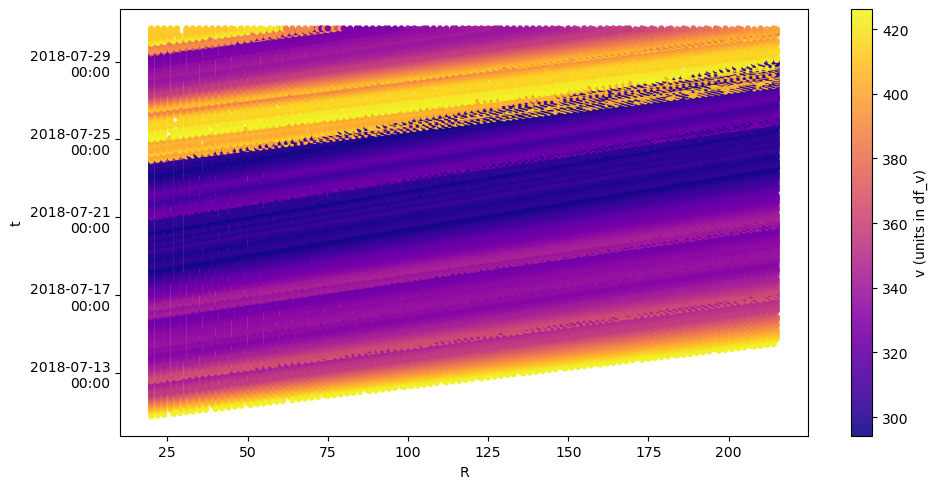

In [40]:
# plot t vs R with v as color
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

tmp = df.xs(120.0, level="phi").reset_index()  # index -> columns: date, R, v
tmp["date"] = pd.to_datetime(tmp["date"])

# reduce v lists to a scalar (mean) and drop empties
tmp["v_scalar"] = tmp["v"].apply(
    lambda x: (
        np.nan
        if (not isinstance(x, (list, tuple, np.ndarray)) or len(x) == 0)
        else x[-1]
    )
)
plot_df = tmp.dropna(subset=["v_scalar"])

plt.figure(figsize=(10, 5))
sc = plt.scatter(
    plot_df["R"],
    plot_df["date"],
    c=plot_df["v_scalar"],
    cmap="plasma",
    s=12,
    alpha=0.9,
)
plt.colorbar(sc, label="v (units in df_v)")
plt.xlabel("R")
plt.ylabel("t")
ax = plt.gca()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
plt.tight_layout()
plt.show()
# ...existing code...

In [41]:
df_head = df.head(2000)

In [42]:
# compute global v min/max across the whole dataframe (extract scalar from lists)
v_scalar_all = df["v"].apply(
    lambda x: np.nan
    if (not isinstance(x, (list, tuple, np.ndarray)) or len(x) == 0)
    else max(x)
)
vmin = 150
vmax = float(v_scalar_all.max())

In [43]:
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import numpy as np

# prepare date options (strings for the slider)
dates = sorted(df.index.get_level_values("date").unique())
date_strs = [d.strftime("%Y-%m-%d %H:%M:%S") for d in dates]

def plot_polar(date_str):
    d = pd.Timestamp(date_str)
    # select rows for the chosen date
    try:
        tmp = df.xs(d, level="date").reset_index()  # columns: phi, R, v
    except KeyError:
        print("No data for", date_str)
        return

    # convert stored v lists to a scalar (use last value here)
    tmp["v_scalar"] = tmp["v"].apply(
        lambda x: np.nan
        if (not isinstance(x, (list, tuple, np.ndarray)) or len(x) == 0)
        else max(x)
    )
    tmp = tmp.dropna(subset=["v_scalar"])
    if tmp.empty:
        print("No v values for", date_str)
        return

    phi_rad = np.deg2rad(tmp["phi"].astype(float))
    r = tmp["R"].astype(float)
    c = tmp["v_scalar"].astype(float)

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(projection="polar")
    sc = ax.scatter(phi_rad, r, c=c, cmap="plasma", s=1, alpha=0.9, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(sc, pad=0.1)
    cb.set_label("v")
    ax.set_title(f"phi-R (polar) at {date_str}")
    # optional: set r limits if desired
    ax.set_ylim(tmp["R"].min() - 1, tmp["R"].max() + 1)
    plt.show()

# interactive slider (use continuous_update=False for performance)
interact(
    plot_polar,
    date_str=widgets.SelectionSlider(
        options=date_strs, value=date_strs[0], description="date", continuous_update=False, layout=widgets.Layout(width="90%")
    ),
)


interactive(children=(SelectionSlider(continuous_update=False, description='date', layout=Layout(width='90%'),…

<function __main__.plot_polar(date_str)>

In [44]:
215 * np.sin(np.deg2rad(3)) 

np.float64(11.252230592232925)

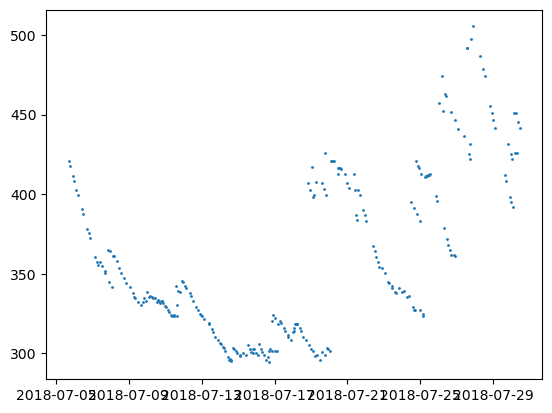

In [45]:
ddf = df.xs(0.0, level="phi").xs(215, level="R")
ddf["v"] = ddf["v"].apply(lambda x: np.nan if len(x) == 0 else max(x))
ddf.dropna(inplace=True)
plt.scatter(ddf.index, ddf["v"], s=1)

In [ ]:
df.to_parquet("./Outputs/Propagated SW.parquet")